In [1]:
from sklearn.datasets import make_circles

n_samples = 1000
X , y = make_circles(n_samples,noise=0.03,random_state=42)

In [2]:
X[:5] , y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [3]:
import pandas as pd

circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
circles['label'].value_counts()

label
1    500
0    500
Name: count, dtype: int64

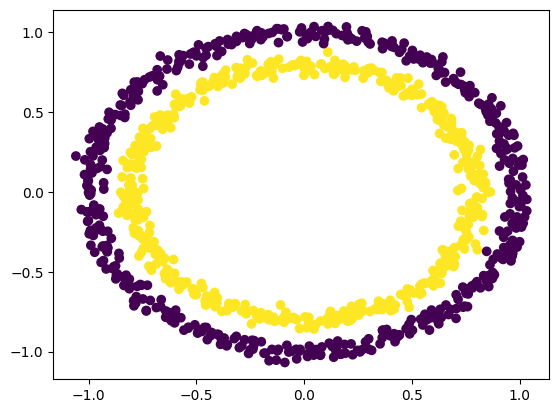

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y)

In [6]:
X.shape , y.shape

((1000, 2), (1000,))

In [7]:
X[0] , y[0]

(array([0.75424625, 0.23148074]), 1)

In [8]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5] , y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
device

'cpu'

In [12]:
from torch import nn

In [13]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2,5)
        self.layer2 = nn.Linear(5,1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
untrained_preds = model0(X_test.to(device))
untrained_preds[:10]

tensor([[-0.6087],
        [-0.5442],
        [-0.4842],
        [-0.6451],
        [-0.0186],
        [ 0.0172],
        [-0.1705],
        [-0.0378],
        [-0.5041],
        [-0.5348]], grad_fn=<SliceBackward0>)

In [15]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model0.parameters(),lr=0.1)

In [16]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [17]:
y_logits = model0(X_test)[:5]

In [18]:
y_logits

tensor([[-0.6087],
        [-0.5442],
        [-0.4842],
        [-0.6451],
        [-0.0186]], grad_fn=<SliceBackward0>)

In [19]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3524],
        [0.3672],
        [0.3813],
        [0.3441],
        [0.4954]], grad_fn=<SigmoidBackward0>)

In [21]:
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [23]:
y_pred_labels = torch.round(torch.sigmoid(model0(X_test)[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [31]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    model0.train()
    y_logits = model0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_train,y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model0.eval()
    with torch.inference_mode():
        test_logits = model0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71279, Accuracy: 42.75% | Test loss: 0.70945, Test acc: 45.00%
Epoch: 10 | Loss: 0.70171, Accuracy: 48.38% | Test loss: 0.69967, Test acc: 46.50%
Epoch: 20 | Loss: 0.69818, Accuracy: 50.00% | Test loss: 0.69670, Test acc: 46.50%
Epoch: 30 | Loss: 0.69683, Accuracy: 49.88% | Test loss: 0.69570, Test acc: 46.50%
Epoch: 40 | Loss: 0.69615, Accuracy: 50.12% | Test loss: 0.69531, Test acc: 48.00%
Epoch: 50 | Loss: 0.69573, Accuracy: 50.12% | Test loss: 0.69512, Test acc: 49.00%
Epoch: 60 | Loss: 0.69540, Accuracy: 50.12% | Test loss: 0.69501, Test acc: 49.50%
Epoch: 70 | Loss: 0.69514, Accuracy: 49.75% | Test loss: 0.69494, Test acc: 51.50%
Epoch: 80 | Loss: 0.69491, Accuracy: 49.62% | Test loss: 0.69488, Test acc: 51.50%
Epoch: 90 | Loss: 0.69471, Accuracy: 49.50% | Test loss: 0.69483, Test acc: 51.50%


In [32]:
import requests
from pathlib import Path 

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

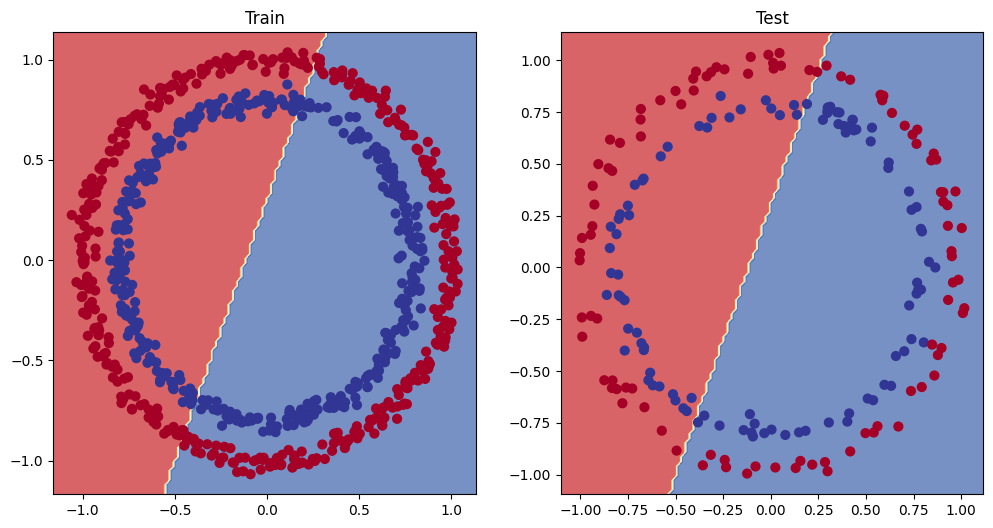

In [34]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

In [35]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModelV2()
print(model_1)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [36]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [38]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_train,y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test loss: 0.62145, Test acc: 79.00%


In [40]:
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

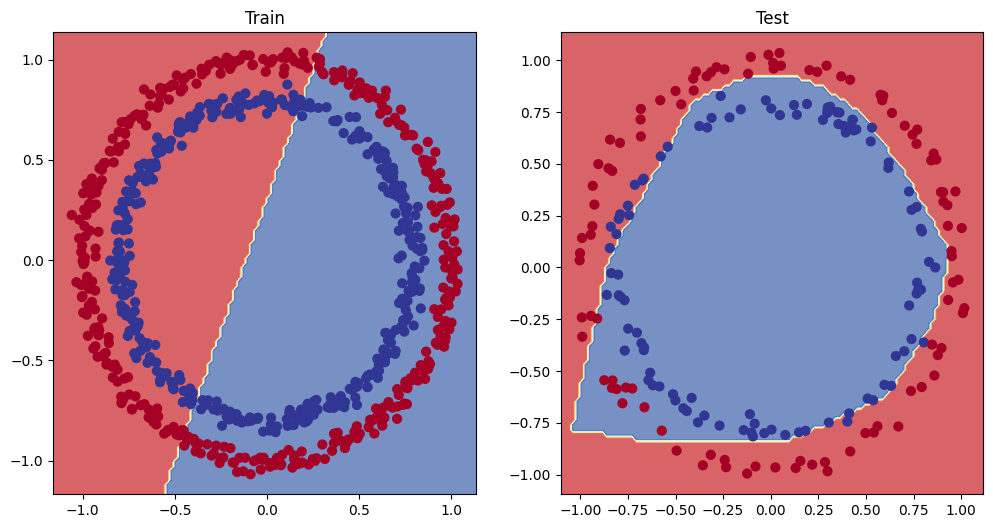

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train) # no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test) # has non-linearity

In [42]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5, 
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob[:5] , y_blob[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3, 2, 2, 1, 1]))

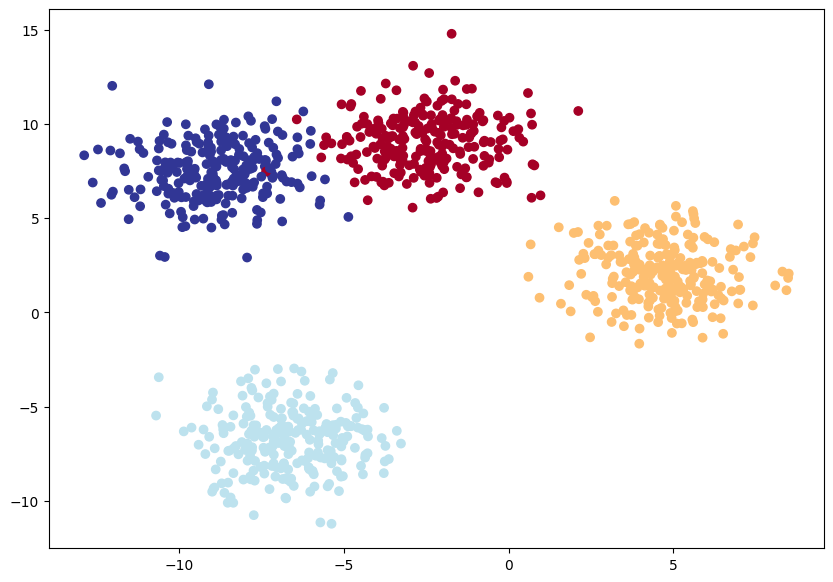

In [43]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [44]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

model_2 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8)
model_2

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(),lr=0.1)

In [47]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    model_2.train()
    y_logits = model_2(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_blob_train,y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_2.eval()
    with torch.inference_mode():
      test_logits = model_2(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_blob_test,test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.03185, Acc: 99.12% | Test Loss: 0.02293, Test Acc: 99.50%
Epoch: 10 | Loss: 0.03093, Acc: 99.12% | Test Loss: 0.02186, Test Acc: 99.50%
Epoch: 20 | Loss: 0.03017, Acc: 99.12% | Test Loss: 0.02097, Test Acc: 99.50%
Epoch: 30 | Loss: 0.02955, Acc: 99.12% | Test Loss: 0.02022, Test Acc: 99.50%
Epoch: 40 | Loss: 0.02902, Acc: 99.12% | Test Loss: 0.01958, Test Acc: 99.50%
Epoch: 50 | Loss: 0.02857, Acc: 99.12% | Test Loss: 0.01902, Test Acc: 99.50%
Epoch: 60 | Loss: 0.02819, Acc: 99.12% | Test Loss: 0.01852, Test Acc: 99.50%
Epoch: 70 | Loss: 0.02785, Acc: 99.12% | Test Loss: 0.01809, Test Acc: 99.50%
Epoch: 80 | Loss: 0.02756, Acc: 99.12% | Test Loss: 0.01770, Test Acc: 99.50%
Epoch: 90 | Loss: 0.02730, Acc: 99.12% | Test Loss: 0.01735, Test Acc: 99.50%


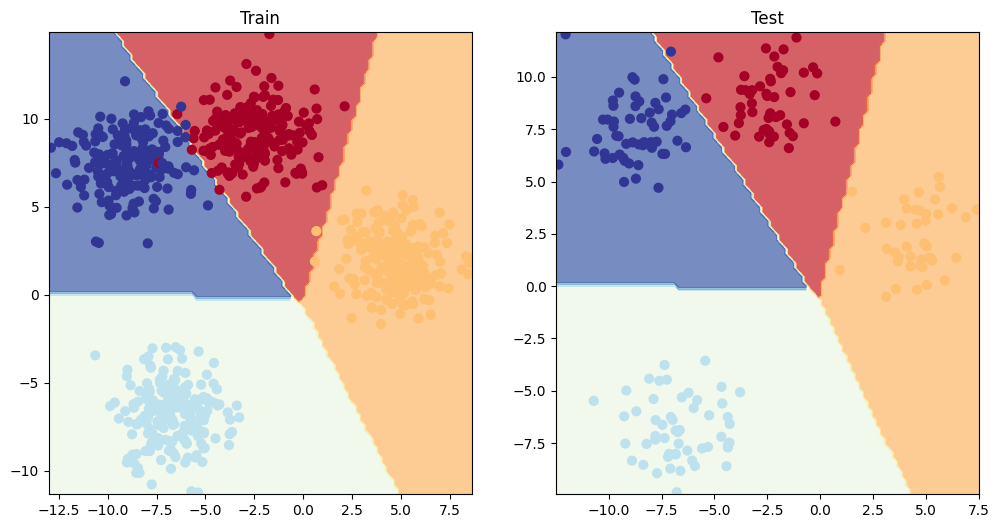

In [48]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_blob_test, y_blob_test)